# Model Architecture

Leveraging multi-GPU parallelism, our architecture enhances processing efficiency for image captioning tasks.
### Encoder Class
Core: Utilizes a Pre-trained ResNet-50 for robust image feature extraction.
Standardization: Features are adaptively pooled for decoder uniformity.
### Decoder Class
- Function: Converts image features into coherent captions.
- Key Components:
    - Embedding Layer: Token to vector translation.
    - LSTM Layer: Integrates token sequence and image features
    - Linear Layer: Projects LSTM output to vocabulary for next token prediction.
    
   
### Enhancements :
Incorporates PyTorch Autgrad for mixed precision operations
Efficiency: Employs .to(device) for optimized GPU distribution, enabling larger batch and image processing

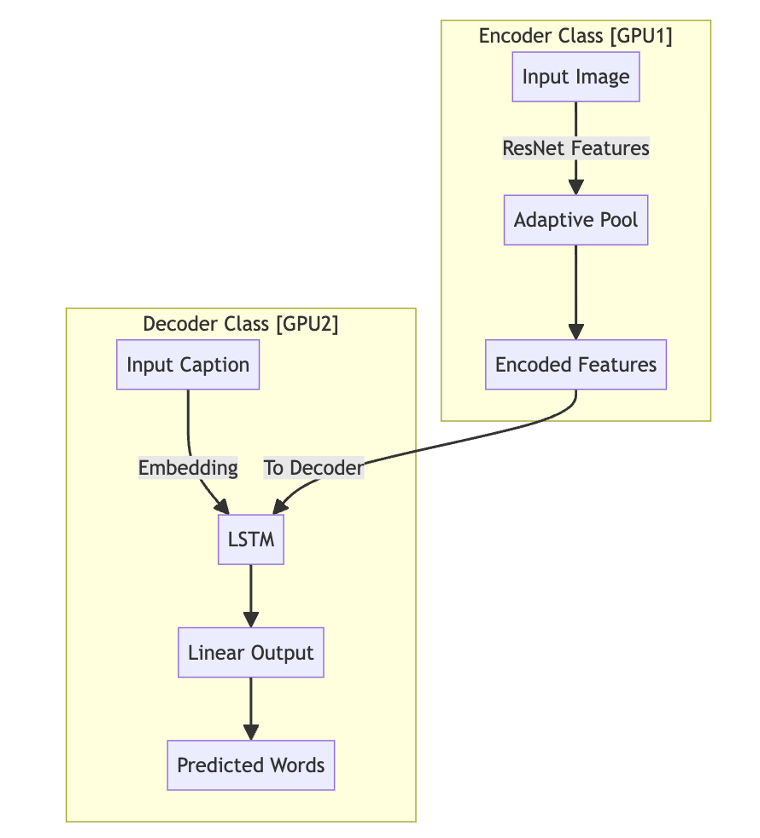

# Experiment Matrix

#### Objective: 
- Evaluate three parallelism techniques across various configurations.

#### Techniques:
- Data Parallelism with Distributed Data Parallel (DDP)
- Model Parallelism
- Mixed Precision

## List of Experiments 

- **Exp 1**: Single GPU - Batch 128 - Mixed Precision OFF (Not yet attempted)
- **Exp 2**: Single GPU - Batch 128 - Mixed Precision ON (Currently in progress)
- **Exp 3**: DDP (Distributed Data Parallel) - 1 GPU - Mixed Precision OFF (Not yet attempted)
- **Exp 4**: DDP - 1 GPU - Mixed Precision ON (Not yet attempted)
- **Exp 5**: DDP - 2 GPU - Mixed Precision OFF (Not yet attempted)
- **Exp 6**: DDP - 2 GPU - Mixed Precision ON (Not yet attempted)
- **Exp 7**: DDP - 3 GPU - Mixed Precision OFF (Not yet attempted)
- **Exp 8**: DDP - 3 GPU - Mixed Precision ON (Not yet attempted)
- **Exp 9**: Model Parallel - 2 GPU - Mixed Precision ON (Not yet attempted)
- **Exp 10**: Model Parallel - 3 GPU - Mixed Precision ON (Not yet attempted)
- **Exp 11**: Model Parallel - 2 GPU - Mixed Precision OFF (Not yet attempted)
- **Exp 12**: Model Parallel - 3 GPU - Mixed Precision OFF (Not yet attempted)


# Before we begin with the Experiments

## Let's get a basic setup done

## Importing Libraries

In [1]:
import torch
import torch
import torch.distributed as dist
from torch.multiprocessing import spawn
import torch
print(torch.__version__)
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import json 
from collections import Counter
from tqdm import tqdm
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler
from tqdm import tqdm
from pycocotools.coco import COCO
import requests
import os
import matplotlib.pyplot as plt
import torch.optim as optim

import torch
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset
from nltk.tokenize import word_tokenize
import time
import multiprocessing
import matplotlib.pyplot as plt
from torchvision.datasets import CocoDetection
import numpy as np
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from torchvision import models
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

import os
import torch
import torch.distributed as dist
import torch.multiprocessing as mp


2.2.2+cu121


[nltk_data] Downloading package punkt to /home/surve.de/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Checking the resources we have

In [2]:
# Check if CUDA is available
if torch.cuda.is_available():
    # Get the CUDA device count
    device_count = torch.cuda.device_count()
    print(f"Number of CUDA devices: {device_count}")

    # Iterate over each CUDA device
    for i in range(device_count):
        # Get the properties of the current CUDA device
        device = torch.device(f'cuda:{i}')
        properties = torch.cuda.get_device_properties(device)
        
        # Print the name and memory info of the current CUDA device
        print(f"Device {i}: {properties.name}, Memory: {properties.total_memory / 1024**3:.2f} GB")
        
        # Check GPU memory usage
        memory_allocated = torch.cuda.memory_allocated(device) / 1024**3  # in GB
        print(f"Memory being used: {memory_allocated:.2f} GB")
else:
    print("CUDA is not available. Make sure you have CUDA installed and configured properly.")

Number of CUDA devices: 3
Device 0: Tesla V100-SXM2-32GB, Memory: 31.74 GB
Memory being used: 0.00 GB
Device 1: Tesla V100-SXM2-32GB, Memory: 31.74 GB
Memory being used: 0.00 GB
Device 2: Tesla V100-SXM2-32GB, Memory: 31.74 GB
Memory being used: 0.00 GB


## Setting dataset paths

In [3]:
# annotations = "/scratch/surve.de/caption_data_10k.json"
# image_dir = "/scratch/surve.de/images2"

annotations = "/scratch/surve.de/caption_data_75k.json"
image_dir = "/scratch/surve.de/devesh/COCO"

## Building Vocabulary Object with Annotations

In [4]:
class Vocabulary:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

        # Add special tokens
        self.add_word('<pad>')
        self.add_word('<start>')
        self.add_word('<end>')
        self.add_word('<unk>')

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if word not in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)



def build_vocabulary(data, threshold):
    """Builds a vocabulary from the dataset captions.

    Args:
        data (list): List of dictionaries with 'image' and 'caption'.
        threshold (int): Minimum word frequency to be included in the vocabulary.

    Returns:
        Vocabulary: The constructed vocabulary.
    """
    counter = Counter()
    for item in data:
        tokens = word_tokenize(item['caption'].lower())
        counter.update(tokens)

    # Create a vocabulary
    vocab = Vocabulary()

    # Add words to the vocabulary if they meet the frequency threshold
    for word, count in counter.items():
        if count >= threshold:
            vocab.add_word(word)

    return vocab


with open(annotations, 'r') as f:
    json_data = json.load(f)

ann = []

for filename, data in json_data.items():
    image_id = data['image_id']
    caption = data['caption']
    ann.append({"image": filename, "caption": caption})

vocab = build_vocabulary(ann, 1)

## Create Image Caption Dataset to Load Images

In [5]:
def collate_fn(batch):
    """
    Custom collate function to pad captions to the same length in each batch.
    
    Args:
        batch: List of tuples (image, caption), where caption is a tensor of word indices.
    
    Returns:
        images: Tensor of all images in the batch.
        captions: Tensor of all padded captions in the batch.
    """
    # Separate the images and captions
    images, captions = zip(*batch)

    # Convert images to a tensor
    images = torch.stack(images, 0)

    # Pad the captions to the maximum length caption in the batch
    captions = pad_sequence(captions, batch_first=True, padding_value=0) # Assuming 0 is the index for <pad>

    return images, captions


class ImageCaptionDataset(Dataset):
    def __init__(self, img_dir, data, vocab, transform=None):
        """
        Args:
            img_dir (string): Directory with all the images.
            data (list): List of dictionaries with 'image' and 'caption'.
            vocab (Vocabulary): Vocabulary instance.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.img_dir = img_dir
        self.data = data
        self.vocab = vocab
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load image
        img_name = os.path.join(self.img_dir, self.data[idx]['image'])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # Convert caption to list of word indices
        caption = self.data[idx]['caption']
        tokens = word_tokenize(caption.lower())
        caption_indices = [self.vocab('<start>')] + [self.vocab(token) for token in tokens] + [self.vocab('<end>')]
        
        return image, torch.tensor(caption_indices)
    

dataset = ImageCaptionDataset(img_dir=image_dir, data=ann, vocab=vocab)

# Let's retrieve the first sample to see how it looks
img, caption_indices = dataset[0]
print("Image shape:", img.shape)
print("Caption indices:", caption_indices)

Image shape: torch.Size([3, 224, 224])
Caption indices: tensor([ 1,  4,  5,  6,  7,  8,  4,  9, 10, 11, 12, 13,  2])


## Visualize Image + Caption

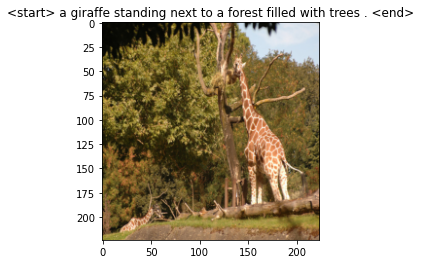

In [6]:
# Visualizing the image and its caption

plt.imshow(img.permute(1, 2, 0))
plt.title(' '.join([dataset.vocab.idx2word[idx.item()] for idx in caption_indices]))
plt.show()

Batch images shape: torch.Size([128, 3, 224, 224])
Batch captions shape: torch.Size([128, 30])


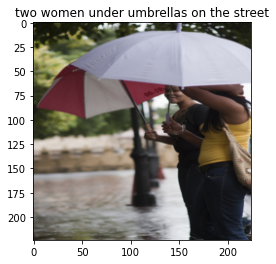

In [7]:
# Define the batch size
batch_size = 128

data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, 
                         num_workers=4, pin_memory=True, collate_fn=collate_fn)


# Fetch one batch of data
for images, captions in data_loader:
    print("Batch images shape:", images.shape)
    print("Batch captions shape:", captions.shape)
    break  # We only want to check the first batch

# Optional: Visualize an image from the batch with its caption
img = images[0]  # First image in the batch
caption = captions[0]  # Corresponding caption
plt.imshow(img.permute(1, 2, 0))
plt.title(' '.join([vocab.idx2word[idx.item()] for idx in caption if idx not in [vocab('<start>'), vocab('<end>'), vocab('<pad>')]]))
plt.show()

## Defining the Encoder Decoder for Single GPU for Model Object

In [8]:
class Encoder_SingleGPU(nn.Module):
    def __init__(self, encoded_image_size=14):
        super(Encoder_SingleGPU, self).__init__()
        resnet = models.resnet50(pretrained=True)
        
        # Remove linear and pool layers (since we're not doing classification)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        
        # Resize image to fixed size to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

    def forward(self, images):
        features = self.resnet(images)
        features = self.adaptive_pool(features)
        features = features.view(features.size(0), -1)  # Flatten the features
        return features


class Decoder_SingleGPU(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(Decoder_SingleGPU, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, features, captions):
        features = features.to("cuda:1")
        embeddings = self.embed(captions)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


# Implementing Data Parallelism with DDP
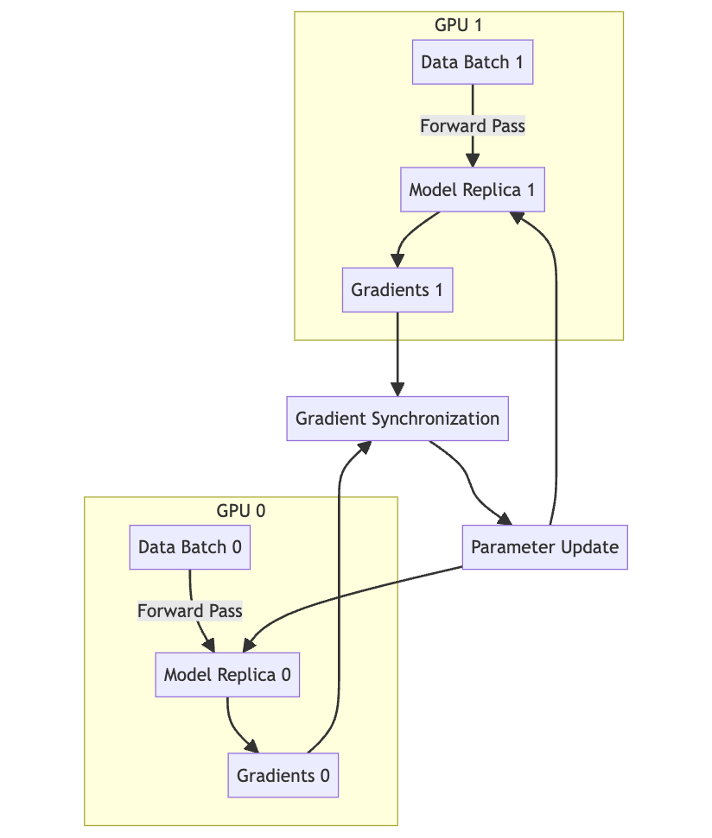
- Implementing Data Parallelism with Distributed Data Parallel (DDP) 
- What is Data Parallelism?:
    - Splitting the data across multiple GPUs 
    - Performing simultaneous computation
    - DDP synchronizes the gradients across the GPUs during the backward pass,
- DDP in PyTorch:
    - The DistributedDataParallel (DDP) wrapper in PyTorch 
    - Enables easy implementation of data parallelism by automating gradient collection and parameter updates.
    - Models are replicated on each device 
    - Each model replica operates on a subset of the data.


- Applying DDP to Our Image Captioning Model:
    - Model leverage DDP for data parallelism across multiple GPUs 
    - Goal is to help to improve training times.
    - Split the COCO dataset into mini-batches distributed across the GPUs, with each GPU computing a segment of the data.
    - Post-forward pass, DDP synchronizes gradients across the devices to update model parameters uniformly.


## **NOTE** : 

### We have run every experiment once and saved the loss + time since 13 experiments won't fit inside 3 GPUs

# **Exp 1**: Single GPU - Batch 128 - Mixed Precision OFF


### Defining Training Function

In [9]:
# def train_model_single(encoder, decoder, data_loader, optimizer, criterion, num_epochs, use_mixed_precision=False):
#     encoder.train()
#     decoder.train()
    
#     metrics = {
#         'time': [],
#         'loss': []
#     }

#     scaler = torch.cuda.amp.GradScaler(enabled=use_mixed_precision)

#     for epoch in range(num_epochs):
#         epoch_start_time = time.time()
#         total_loss = 0

#         for images, captions in data_loader:
#             images, captions = images.to(device), captions.to(device)

#             optimizer.zero_grad()

#             with torch.cuda.amp.autocast(enabled=use_mixed_precision):
#                 features = encoder(images)
#                 outputs = decoder(features, captions[:, :-1])
#                 loss = criterion(outputs.view(-1, vocab_size), captions[:, 1:].reshape(-1))

#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()

#             total_loss += loss.item()

#         epoch_time = time.time() - epoch_start_time
#         metrics['time'].append(epoch_time)
#         metrics['loss'].append(total_loss / len(data_loader))

#         print(f"Epoch {epoch+1}, Loss: {metrics['loss'][-1]}, Time: {metrics['time'][-1]} sec")

#     return metrics


# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# vocab_size = len(vocab)  # Your vocabulary size
# embed_size = 256  # Size of the word embeddings
# hidden_size = 512  # Size of the hidden states in the LSTM
# num_layers = 1  # Number of layers in the LSTM
# num_epochs = 5

# encoder = Encoder_SingleGPU().to(device)
# decoder = Decoder_SingleGPU(embed_size, hidden_size, vocab_size, num_layers).to(device)

# criterion = nn.CrossEntropyLoss().to(device)
# params = list(decoder.parameters()) + list(encoder.resnet.parameters())
# optimizer = optim.Adam(params, lr=0.001)

# print("\n------------------\n")
# print("Training without Mixed Precision")
# print("\n------------------\n")
 
# # Resetting for a new training run
# encoder = Encoder_SingleGPU().to(device)
# decoder = Decoder_SingleGPU(embed_size, hidden_size, vocab_size, num_layers).to(device)
# params = list(decoder.parameters()) + list(encoder.parameters())
# optimizer = optim.Adam(params, lr=0.001)
# scaler = torch.cuda.amp.GradScaler()  # Only necessary if using mixed precision
 
# # Now you can start a new training session
# metrics_exp_1 = train_model_single(encoder, decoder, data_loader, optimizer, criterion, num_epochs=num_epochs, use_mixed_precision=False)

In [10]:
# exp1 = {"Exp 1: Single GPU - Batch 128 - Mixed Precision OFF" : metrics_exp_1}
# print(exp1)

In [11]:

# with open('exp1.pkl', 'wb') as fp:
#     pickle.dump(exp1, fp)

### View Saved Output

In [12]:
import pickle

pkl_file = "exp1.pkl"
with open(pkl_file, "rb") as f:
    # Load data from the current .pkl file
    data = pickle.load(f)

print(data)

{'Exp 1: Single GPU - Batch 128 - Mixed Precision OFF': {'time': [195.8782820701599, 201.85147905349731, 201.78040623664856, 203.55595588684082, 204.43655443191528], 'loss': [2.049725360939527, 1.5855304046499037, 1.46459326951577, 1.380839085314461, 1.3215047795414518]}}


# **Exp 2**: Single GPU - Batch 128 - Mixed Precision ON 

### Defining Training Function

In [13]:
# def train_model_single(encoder, decoder, data_loader, optimizer, criterion, num_epochs, use_mixed_precision=False):
#     encoder.train()
#     decoder.train()
    
#     metrics = {
#         'time': [],
#         'loss': []
#     }

    scaler = torch.cuda.amp.GradScaler(enabled=use_mixed_precision)

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        total_loss = 0

        for images, captions in data_loader:
            images, captions = images.to(device), captions.to(device)

            optimizer.zero_grad()

            with torch.cuda.amp.autocast(enabled=use_mixed_precision):
                features = encoder(images)
                outputs = decoder(features, captions[:, :-1])
                loss = criterion(outputs.view(-1, vocab_size), captions[:, 1:].reshape(-1))

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        epoch_time = time.time() - epoch_start_time
        metrics['time'].append(epoch_time)
        metrics['loss'].append(total_loss / len(data_loader))

        print(f"Epoch {epoch+1}, Loss: {metrics['loss'][-1]}, Time: {metrics['time'][-1]} sec")

#     return metrics


# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# vocab_size = len(vocab)  # Your vocabulary size
# embed_size = 256  # Size of the word embeddings
# hidden_size = 512  # Size of the hidden states in the LSTM
# num_layers = 1  # Number of layers in the LSTM

# encoder = Encoder_SingleGPU().to(device)
# decoder = Decoder_SingleGPU(embed_size, hidden_size, vocab_size, num_layers).to(device)

# criterion = nn.CrossEntropyLoss().to(device)
# params = list(decoder.parameters()) + list(encoder.resnet.parameters())
# optimizer = optim.Adam(params, lr=0.001)

# print("\n------------------\n")
# print("Training with Mixed Precision")
# print("\n------------------\n")
 
# # Resetting for a new training run
# encoder = Encoder_SingleGPU().to(device)
# decoder = Decoder_SingleGPU(embed_size, hidden_size, vocab_size, num_layers).to(device)
# params = list(decoder.parameters()) + list(encoder.parameters())
# optimizer = optim.Adam(params, lr=0.001)
# scaler = torch.cuda.amp.GradScaler()  # Only necessary if using mixed precision
 
# # Now you can start a new training session
# metrics_exp_1 = train_model_single(encoder, decoder, data_loader, optimizer, criterion, num_epochs=5, use_mixed_precision=True)

In [14]:
# exp2 = {"Exp 2: Single GPU - Batch 128 - Mixed Precision ON" : metrics_exp_1}
# print(exp2)

# with open('exp2.pkl', 'wb') as fp:
#     pickle.dump(exp2, fp)

### View Saved Output

In [15]:
import pickle

pkl_file = "exp2.pkl"
with open(pkl_file, "rb") as f:
    # Load data from the current .pkl file
    data = pickle.load(f)

print(data)

{'Exp 2: Single GPU - Batch 128 - Mixed Precision ON': {'time': [196.1182506084442, 203.1674723625183, 203.16124868392944, 203.09461212158203, 202.19495153427124], 'loss': [2.0311579216055495, 1.587125048397344, 1.4599539457531105, 1.3929916254082637, 1.3105534223566284]}}


# **Exp 3**: DDP (Distributed Data Parallel) - 1 GPU - Mixed Precision OFF


In [16]:
# from logs.my_test import train

# def main():
#     world_size = 1
#     mp.spawn(train, args=(world_size,"exp3", False, 128, "Exp 3: Single GPU - Batch 128 - Mixed Precision OFF"), nprocs=world_size, join=True)

# if __name__ == "__main__":
#     main()

### View Saved Output

In [17]:
import pickle

pkl_file = "exp3.pkl"
with open(pkl_file, "rb") as f:
    # Load data from the current .pkl file
    data = pickle.load(f)

print(data)

{'Exp 3: Single GPU - Batch 128 - Mixed Precision ON': {'time': [316.7313196659088, 250.67753839492798, 248.06169486045837, 251.102933883667, 252.9388928413391], 'loss': [2.0386310312324825, 1.5877839486550145, 1.4746627613342662, 1.3909562696979314, 1.31860200058885]}}


# **Exp 4**: DDP - 1 GPU - Mixed Precision ON 

In [18]:
# from logs.my_test import train

# def main():
#     world_size = 1
#     mp.spawn(train, args=(world_size,"exp4", True, 256, "Exp 4: DDP - 1 GPU - Mixed Precision ON"), nprocs=world_size, join=True)

# if __name__ == "__main__":
#     main()

### View Saved Output

In [19]:
import pickle

# List of paths to your .pkl files
pkl_file = "exp4.pkl"

with open(pkl_file, "rb") as f:
    # Load data from the current .pkl file
    data = pickle.load(f)

# Now combined_data contains the combined contents of all .pkl files
print(data)

{'Exp 4: DDP - 1 GPU - Mixed Precision ON': {'time': [240.84544444084167, 244.35891842842102, 244.29667401313782, 240.132728099823, 247.8566906452179], 'loss': [2.0612009155465474, 1.5080920563622953, 1.3899441648261945, 1.317382052489922, 1.2619852507073726]}}


# **Exp 5**: DDP - 2 GPU - Mixed Precision OFF


In [20]:
# from logs.my_test import train

# def main():
#     world_size = 2
#     mp.spawn(train, args=(world_size,"exp5", False, 128, "Exp 5: DDP - 2 GPU - Mixed Precision OFF"), nprocs=world_size, join=True)

# if __name__ == "__main__":
#     main()

In [21]:
import pickle

# List of paths to your .pkl files
pkl_file = "exp5.pkl"

with open(pkl_file, "rb") as f:
    # Load data from the current .pkl file
    data = pickle.load(f)

# Now combined_data contains the combined contents of all .pkl files
print(data)

{'Exp 5: DDP - 2 GPU - Mixed Precision OFF': {'time': [156.6845350265503, 157.0435435771942, 160.8118872642517, 158.32311248779297, 154.29067015647888], 'loss': [2.2763518876183153, 1.669137088511991, 1.5313223230147117, 1.4607495283104046, 1.415887695123718]}}


# **Exp 6**: DDP - 2 GPU - Mixed Precision ON 

In [22]:
# from logs.my_test import train

# def main():
#     world_size = 2
#     mp.spawn(train, args=(world_size,"exp6", True, 256, "Exp 6: DDP - 2 GPU - Mixed Precision ON"), nprocs=world_size, join=True)

# if __name__ == "__main__":
#     main()

In [23]:
import pickle

# List of paths to your .pkl files
pkl_file = "exp6.pkl"

with open(pkl_file, "rb") as f:
    # Load data from the current .pkl file
    data = pickle.load(f)

# Now combined_data contains the combined contents of all .pkl files
print(data)

{'Exp 6: DDP - 2 GPU - Mixed Precision ON': {'time': [147.37107372283936, 151.43446731567383, 150.54707980155945, 151.98750233650208, 151.7225353717804], 'loss': [2.395582889213043, 1.6292201682012908, 1.475288222841665, 1.4309892869320044, 1.3541061630865343]}}


# **Exp 7**: DDP - 3 GPU - Mixed Precision OFF

In [24]:
# from logs.my_test import train

# def main():
#     world_size = 3
#     mp.spawn(train, args=(world_size,"exp7", False, 128, "Exp 7: DDP - 3 GPU - Mixed Precision OFF"), nprocs=world_size, join=True)

# if __name__ == "__main__":
#     main()

In [25]:
import pickle

# List of paths to your .pkl files
pkl_file = "exp7.pkl"

with open(pkl_file, "rb") as f:
    # Load data from the current .pkl file
    data = pickle.load(f)

# Now combined_data contains the combined contents of all .pkl files
print(data)

{'Exp 7: DDP - 3 GPU - Mixed Precision OFF': {'time': [150.6877257823944, 156.6349093914032, 155.78683710098267, 153.7385184764862, 159.39115977287292], 'loss': [2.4359909183516795, 1.757936386733639, 1.620464017804788, 1.504227916196901, 1.470357818567023]}}


# **Exp 8**: DDP - 3 GPU - Mixed Precision ON 

In [26]:
# from logs.my_test import train

# def main():
#     world_size = 3
#     mp.spawn(train, args=(world_size,"exp8", True, 256, "Exp 8: DDP - 3 GPU - Mixed Precision ON"), nprocs=world_size, join=True)

# if __name__ == "__main__":
#     main()

In [27]:
import pickle

# List of paths to your .pkl files
pkl_file = "exp8.pkl"

with open(pkl_file, "rb") as f:
    # Load data from the current .pkl file
    data = pickle.load(f)

# Now combined_data contains the combined contents of all .pkl files
print(data)

{'Exp 8: DDP - 3 GPU - Mixed Precision ON': {'time': [140.5703821182251, 146.43881511688232, 144.53928065299988, 142.90805768966675, 141.54271268844604], 'loss': [2.6631407117357058, 1.7435722630851123, 1.5693513124572986, 1.464410284344031, 1.4071822780735639]}}


# Model Parallelism

### Applying Model Parallelism to Image Captioning:
- We split the encoder and decoder of our image captioning model across different GPUs to demonstrate model parallelism.
- The encoder processes the image on one GPU, while the decoder, residing on another GPU, generates the captions.
- This split allows us to process larger images or more complex encoder-decoder architectures that wouldn't fit on a single GPU.


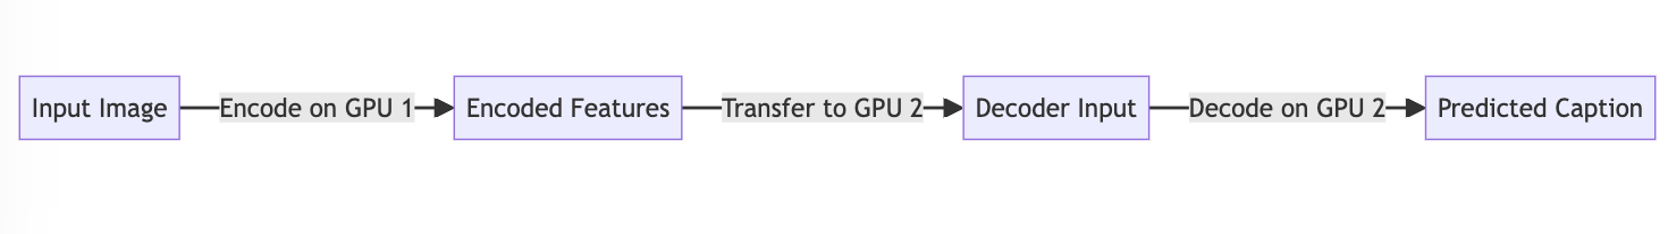

In [30]:
# Supports multiple GPUs
class Encoder_MultiGPU(nn.Module):
    def __init__(self, encoded_image_size=14, device='cuda:0'):
        super(Encoder_MultiGPU, self).__init__()
        self.device = device
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules).to(device)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size)).to(device)
 
    def forward(self, images):
        images = images.to(self.device)
        features = self.resnet(images)
        features = self.adaptive_pool(features)
        features = features.view(features.size(0), -1)
        return features

class Decoder_MultiGPU(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, device1='cuda:1', device2='cuda:2'):
        super(Decoder_MultiGPU, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size).to(device1)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True).to(device1)
        self.linear = nn.Linear(hidden_size, vocab_size).to(device2)
        self.device1 = device1
        self.device2 = device2
 
    def forward(self, features, captions):
        features = features.to(self.device1)
        captions = captions.to(self.device1)
        embeddings = self.embed(captions)
        hiddens, _ = self.lstm(embeddings)
        hiddens = hiddens.to(self.device2)
        outputs = self.linear(hiddens)
        return outputs
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vocab_size = len(vocab)  # Your vocabulary size
embed_size = 256  # Size of the word embeddings
hidden_size = 512  # Size of the hidden states in the LSTM
num_layers = 1  # Number of layers in the LSTM

encoder = Encoder_MultiGPU().to(device)
decoder = Decoder_MultiGPU(embed_size, hidden_size, vocab_size, num_layers).to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss().to(device)
params = list(decoder.parameters()) + list(encoder.resnet.parameters())
optimizer = optim.Adam(params, lr=0.001)

def train_model_multi(encoder, decoder, data_loader, optimizer, criterion, num_epochs, use_mixed_precision=False):
    encoder.train()
    decoder.train()
    metrics = {
        'time': [],
        'loss': []
    }
 
    scaler = torch.cuda.amp.GradScaler(enabled=use_mixed_precision)
 
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        total_loss = 0
 
        for images, captions in data_loader:
            images = images.to('cuda:0')  # Encoder's device
            captions = captions.to('cuda:1')  # Initially to Decoder's LSTM device
 
            optimizer.zero_grad()
 
            with torch.cuda.amp.autocast(enabled=use_mixed_precision):
                features = encoder(images)
                outputs = decoder(features, captions[:, :-1])
                outputs = outputs.to('cuda:2')  # Ensure outputs are on the same device as the linear layer
                captions = captions.to('cuda:2')  # Move captions to the same device as outputs for loss calculation
                loss = criterion(outputs.view(-1, vocab_size), captions[:, 1:].reshape(-1))
 
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
 
            total_loss += loss.item()
 
        epoch_time = time.time() - epoch_start_time
        metrics['time'].append(epoch_time)
        metrics['loss'].append(total_loss / len(data_loader))
 
        print(f"Epoch {epoch+1}, Loss: {metrics['loss'][-1]}, Time: {metrics['time'][-1]} sec")
 
    return metrics


# **Exp 9**: Model Parallel - 2 GPU - Mixed Precision ON 

In [32]:
print("\n------------------\n")
print("Training with Model Parallelism 2 GPU")
print("\n------------------\n")

encoder = Encoder_MultiGPU(encoded_image_size=14, device='cuda:0')
decoder = Decoder_MultiGPU(embed_size, hidden_size, vocab_size, num_layers, device1='cuda:1', device2='cuda:1') 
# Assuming your model's forward method handles moving intermediate tensors between devices as needed
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(params, lr=0.001)
 
# Adjust the train_model function or its invocation to handle model parallel setup if necessary
metrics_model_parallel = train_model_multi(encoder, decoder, data_loader, optimizer, criterion, num_epochs=5, use_mixed_precision=True)

exp1 = {"Exp 9: Model Parallel - 2 GPU - Mixed Precision ON" : metrics_model_parallel}
print(exp1)

with open('exp9.pkl', 'wb') as fp:
    pickle.dump(exp1, fp)


------------------

Training with Model Parallelism 2 GPU

------------------

Epoch 1, Loss: 2.0366939470019356, Time: 213.42812728881836 sec
Epoch 2, Loss: 1.5871364557702388, Time: 172.86827445030212 sec
Epoch 3, Loss: 1.4616427428689833, Time: 170.58276319503784 sec
Epoch 4, Loss: 1.3780371411465133, Time: 170.65970134735107 sec
Epoch 5, Loss: 1.3083988861419236, Time: 174.40069675445557 sec
{'Exp 9: Model Parallel - 2 GPU - Mixed Precision ON': {'time': [213.42812728881836, 172.86827445030212, 170.58276319503784, 170.65970134735107, 174.40069675445557], 'loss': [2.0366939470019356, 1.5871364557702388, 1.4616427428689833, 1.3780371411465133, 1.3083988861419236]}}


# Saving Model Output

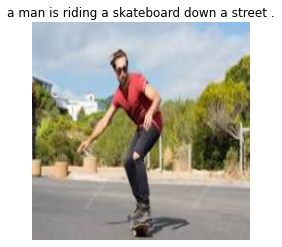

In [45]:
import torch
from PIL import Image
import torchvision.transforms as transforms
from nltk.tokenize import word_tokenize

def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    if transform is not None:
        image = transform(image).unsqueeze(0)  # Add batch dimension.
    return image

import matplotlib.pyplot as plt

def generate_caption_and_plot(image_path, encoder, decoder, vocab, max_length=20):
    # Image preprocessing
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    image = load_image(image_path, transform)
    image_cpu = image.squeeze(0).cpu()  # For plotting, move image back to CPU
    image = image.to('cuda:0')  # Move to GPU, if available
    
    # Generate features from the image
    encoder.eval()  # Evaluation mode
    decoder.eval()
    with torch.no_grad():
        features = encoder(image)
    
    # Prepare the start token
    start_word = [vocab('<start>')]
    start_word = torch.LongTensor(start_word).to('cuda:1')  # Move to the appropriate device
    captions = start_word.unsqueeze(0)  # Add batch dimension
    
    # Generate the caption
    for i in range(max_length):
        with torch.no_grad():
            outputs = decoder(features, captions)
            outputs = outputs.to('cuda:1')  # Move to the device where the final layer is
            predicted = outputs.argmax(2)[:, -1]  # Get the most likely next word
            captions = torch.cat((captions, predicted.unsqueeze(0)), dim=1)  # Add to sequence
            
            # Check if <end> token is generated
            if vocab.idx2word[predicted.item()] == "<end>":
                break
    
    # Convert indices to words
    result_caption = []
    for idx in captions[0]:
        word = vocab.idx2word[idx.item()]
        if word == '<start>':
            continue
        if word == '<end>':
            break
        result_caption.append(word)
    caption = ' '.join(result_caption)
    
    # Plotting the image with its caption
    plt.imshow(transforms.ToPILImage()(image_cpu))
    plt.title(caption)
    plt.axis('off')  # Hide axis
    plt.show()

    return caption

# Assuming you have a vocab object, an encoder, and a decoder already trained, and the image path
image_path = 'man1.jpeg'
caption = generate_caption_and_plot(image_path, encoder, decoder, vocab)


## Saving Model Objects

### Saving the Entire Model
This method saves the serialized model along with its architecture. However, this approach is not recommended for most use cases because it is less flexible and may lead to issues when trying to load the model in a different context.



In [49]:
torch.save(encoder, 'encoder_entire_model.pth')
torch.save(decoder, 'decoder_entire_model.pth')

### Saving the Model State Dictionary
The state dictionary (state_dict) is a Python dictionary object that maps each layer to its parameters (weights and biases). This approach is recommended because it gives you more flexibility for model loading.


In [50]:
torch.save(encoder.state_dict(), 'encoder_state_dict.pth')
torch.save(decoder.state_dict(), 'decoder_state_dict.pth')

# **Exp 10**: Model Parallel - 3 GPU - Mixed Precision ON 

In [51]:
 
print("\n------------------\n")
print("Training with Model Parallelism 3 GPU")
print("\n------------------\n")

encoder = Encoder_MultiGPU(encoded_image_size=14, device='cuda:0')
decoder = Decoder_MultiGPU(embed_size, hidden_size, vocab_size, num_layers, device1='cuda:1', device2='cuda:2') 
# Assuming your model's forward method handles moving intermediate tensors between devices as needed
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(params, lr=0.001)
 
# Adjust the train_model function or its invocation to handle model parallel setup if necessary
metrics_model_parallel = train_model_multi(encoder, decoder, data_loader, optimizer, criterion, num_epochs=5, use_mixed_precision=True)
 
exp1 = {"Exp 10: Model Parallel - 3 GPU - Mixed Precision ON" : metrics_model_parallel}
print(exp1)

with open('exp10.pkl', 'wb') as fp:
    pickle.dump(exp1, fp)    


------------------

Training with Model Parallelism 3 GPU

------------------

Epoch 1, Loss: 2.0536609012315705, Time: 176.2175259590149 sec
Epoch 2, Loss: 1.5886338235168327, Time: 178.48901772499084 sec
Epoch 3, Loss: 1.4781289653973368, Time: 177.30034279823303 sec
Epoch 4, Loss: 1.389188316901796, Time: 176.46345591545105 sec
Epoch 5, Loss: 1.3094959863216804, Time: 175.31381607055664 sec
{'Exp 10: Model Parallel - 3 GPU - Mixed Precision ON': {'time': [176.2175259590149, 178.48901772499084, 177.30034279823303, 176.46345591545105, 175.31381607055664], 'loss': [2.0536609012315705, 1.5886338235168327, 1.4781289653973368, 1.389188316901796, 1.3094959863216804]}}


# **Exp 11**: Model Parallel - 2 GPU - Mixed Precision OFF 

In [52]:
print("\n------------------\n")
print("Training with Model Parallelism 2 GPU")
print("\n------------------\n")

encoder = Encoder_MultiGPU(encoded_image_size=14, device='cuda:0')
decoder = Decoder_MultiGPU(embed_size, hidden_size, vocab_size, num_layers, device1='cuda:1', device2='cuda:1') 
# Assuming your model's forward method handles moving intermediate tensors between devices as needed
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(params, lr=0.001)
 
# Adjust the train_model function or its invocation to handle model parallel setup if necessary
metrics_model_parallel = train_model_multi(encoder, decoder, data_loader, optimizer, criterion, num_epochs=5, use_mixed_precision=True)
 
exp1 = {"Exp 11: Model Parallel - 2 GPU - Mixed Precision OFF" : metrics_model_parallel}
print(exp1)

with open('exp11.pkl', 'wb') as fp:
    pickle.dump(exp1, fp)


------------------

Training with Model Parallelism 2 GPU

------------------

Epoch 1, Loss: 2.0255211236737285, Time: 176.1876220703125 sec
Epoch 2, Loss: 1.5840540714434796, Time: 180.15772914886475 sec
Epoch 3, Loss: 1.4685041602357662, Time: 176.3490424156189 sec
Epoch 4, Loss: 1.3761854947833885, Time: 175.41971158981323 sec
Epoch 5, Loss: 1.318525322569922, Time: 174.98059630393982 sec
{'Exp 11: Model Parallel - 2 GPU - Mixed Precision OFF': {'time': [176.1876220703125, 180.15772914886475, 176.3490424156189, 175.41971158981323, 174.98059630393982], 'loss': [2.0255211236737285, 1.5840540714434796, 1.4685041602357662, 1.3761854947833885, 1.318525322569922]}}


# **Exp 12**: Model Parallel - 3 GPU - Mixed Precision OFF 


In [53]:
print("\n------------------\n")
print("Training with Model Parallelism 3 GPU")
print("\n------------------\n")

encoder = Encoder_MultiGPU(encoded_image_size=14, device='cuda:0')
decoder = Decoder_MultiGPU(embed_size, hidden_size, vocab_size, num_layers, device1='cuda:1', device2='cuda:2') 
# Assuming your model's forward method handles moving intermediate tensors between devices as needed
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(params, lr=0.001)
 
# Adjust the train_model function or its invocation to handle model parallel setup if necessary
metrics_model_parallel = train_model_multi(encoder, decoder, data_loader, optimizer, criterion, num_epochs=5, use_mixed_precision=True)

exp1 = {"Exp 12: Model Parallel - 3 GPU - Mixed Precision OFF" : metrics_model_parallel}
print(exp1)

with open('exp12.pkl', 'wb') as fp:
    pickle.dump(exp1, fp)


------------------

Training with Model Parallelism 3 GPU

------------------

Epoch 1, Loss: 2.0364864131899822, Time: 179.87335920333862 sec
Epoch 2, Loss: 1.58966997825245, Time: 177.2965750694275 sec
Epoch 3, Loss: 1.4627056656843973, Time: 177.65075969696045 sec
Epoch 4, Loss: 1.390010525647284, Time: 179.17869925498962 sec
Epoch 5, Loss: 1.311971348096893, Time: 175.60837697982788 sec
{'Exp 12: Model Parallel - 3 GPU - Mixed Precision OFF': {'time': [179.87335920333862, 177.2965750694275, 177.65075969696045, 179.17869925498962, 175.60837697982788], 'loss': [2.0364864131899822, 1.58966997825245, 1.4627056656843973, 1.390010525647284, 1.311971348096893]}}
